#**Admission Acceptance Rate Prediction with Supervised Modeling**

In [2]:
# Basic libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Model selection & evaluation
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.inspection import permutation_importance

# Regression models
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, VotingRegressor, StackingRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor

# Utilities
from sklearn.base import clone
import shap
from PIL import Image
import os


# **Data Preprocessing**

**Preparing Train and Test Dataset:** Randomizing 20% of the dataset for test set, and 80% of the dataset for train set.

In [4]:
# Load cleaned dataset
df = pd.read_csv('final_dataset_acceptance_rate.csv')
df = df.dropna()


# Feature selection
X = df.drop(columns=['Admission Rate'])  # Drop target and ID columns
y = df['Admission Rate']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Identify numerical and categorical features
categorical_features = ['Cluster']
numeric_features = [col for col in X.columns if col not in categorical_features]


# Preprocessing
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# **Model Evaluation & Selection Functions**

**Cross Validation**

In [5]:

cv = KFold(n_splits=5, shuffle=True, random_state=42)
feature_names = preprocessor.fit(X_train).get_feature_names_out()


**Evaluating Criteria:** CV R2, Test R2 and Adjusted R2 are used to compare the performances of different models.

In [6]:
# Initiate an array to keep track of results across all models
model_results = []

In [7]:
def evaluate_model(name, model):
    # Cross-validated R² scores
    scores = cross_val_score(model, X_train, y_train, scoring='r2', cv=cv)

    y_pred = model.predict(X_test)

    # Core performance metrics
    r2 = r2_score(y_test, y_pred)
    train_r2 = model.score(X_train, y_train)
    n = len(y_test)
    p = model.named_steps['preprocessor'].transform(X_test).shape[1]
    adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)

    # Mean Absolute Percentage Error (caution if y_test has zeros)
    with np.errstate(divide='ignore', invalid='ignore'):
        mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
        mape = np.nan if np.isinf(mape) or np.isnan(mape) else mape

    # Append metrics to the list
    model_results.append({
        'Model': name,
        'CV R²': scores.mean(),
        'CV Std': scores.std(),
        'Train R²': train_r2,
        'Test R²': r2,
        'Adjusted R²': adj_r2,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape
    })
    # Print metrics
    print(f"\n{name}")
    print(f"CV R²:       {scores.mean():.3f}")
    print(f"CV Std:      {scores.std():.3f}")
    print(f"Train R²:    {train_r2:.3f}")
    print(f"Test R²:     {r2:.3f}")
    print(f"Adjusted R²: {adj_r2:.3f}")
    print(f"MSE:         {mse:.3f}")
    print(f"RMSE:        {rmse:.3f}")
    print(f"MAE:         {mae:.3f}")
    if mape is not np.nan:
        print(f"MAPE:        {mape:.2f}%")

    # Optional diagnostic plot
    plt.figure(figsize=(6, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(f"{name} Predictions")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"plots_acceptance_rate/{name}_actual_vs_predicted.png")
    plt.show()

    plt.close()

    return model

**Feature Importance:**
permutation_importance from sklearn.inspection is used to compute the feature importance by permuting the values of each feature and measuring the decrease in the model's performance (in this case, R²). The idea is that if a feature is important, permuting its values should significantly reduce the model’s performance.

In [8]:
# Dictionary to store feature importances from each model
perm_importances = {}

In [9]:
def get_permutation_importance(model, name, perm_importances):
    # Transform the test set using the preprocessor
    X_test_transformed = model.named_steps['preprocessor'].transform(X_test)

    # Calculate permutation importance
    perm = permutation_importance(model.named_steps['regressor'], X_test_transformed, y_test, n_repeats=10, random_state=42)

    # Create a DataFrame to store the feature importance
    perm_df = pd.DataFrame({'Feature': feature_names, 'Importance': perm.importances_mean})

    # Store the permutation importances in the dictionary
    perm_importances[name] = perm_df.sort_values(by='Importance', ascending=False).head(10)

    return perm_importances


# **Supervised Modeling**

**1. Linear Regression**


Linear Regression
CV R²:       0.254
CV Std:      0.045
Train R²:    0.301
Test R²:     0.235
Adjusted R²: 0.148
MSE:         0.789
RMSE:        0.888
MAE:         0.645
MAPE:        171.45%


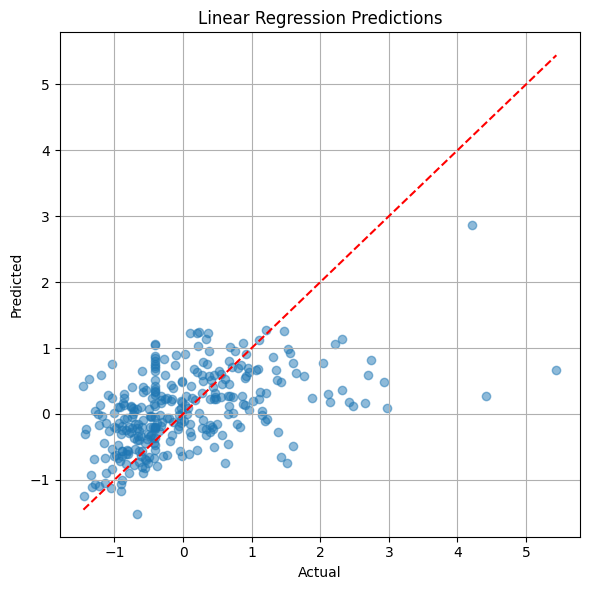

Permutation Importances
                                              Feature  Importance
14                       num__tuition_and_fees_201011    0.161582
9   num__percent_of_total_enrollment_that_are_nati...    0.108357
13     num__percent_of_freshmen_submitting_sat_scores    0.090579
12    num__percent_of_total_enrollment_that_are_white    0.026744
16                  num__offers_associates_degree_Yes    0.013697
19  num__percent_of_total_enrollment_that_are_blac...    0.012764
10  num__percent_of_freshmen__receiving_federal_gr...    0.011176
15                                       num__sat_avg    0.007962
24  num__percent_of_total_enrollment_that_are_two_...    0.006638
27  num__percent_of_graduate_enrollment_that_are_w...    0.005947


In [10]:
# --- Linear Regression ---
linear_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])
model = linear_pipeline.fit(X_train, y_train)
linear_model = evaluate_model("Linear Regression", model)
coefs = linear_model.named_steps['regressor'].coef_
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefs})
print("Permutation Importances")
perm_importances = get_permutation_importance(linear_model, "Linear Regression", perm_importances)
print(perm_importances["Linear Regression"])

**2. Lasso Regression**


Lasso Regression
CV R²:       0.262
CV Std:      0.043
Train R²:    0.292
Test R²:     0.248
Adjusted R²: 0.163
MSE:         0.775
RMSE:        0.880
MAE:         0.637
MAPE:        162.06%


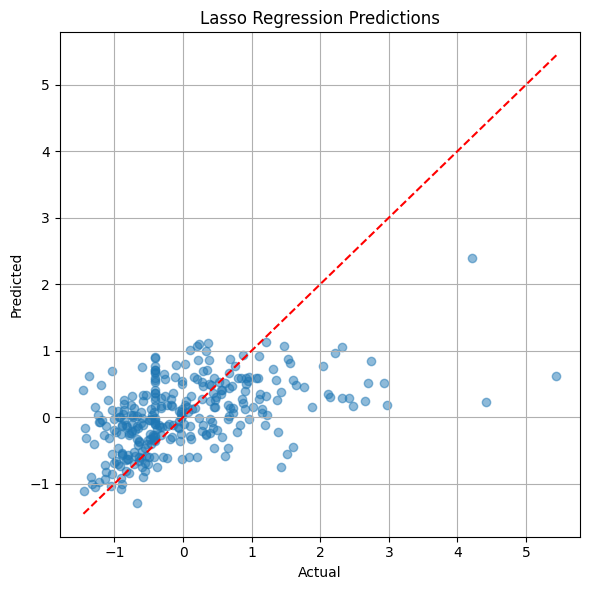

Permutation Importances
                                              Feature  Importance
14                       num__tuition_and_fees_201011    0.192274
9   num__percent_of_total_enrollment_that_are_nati...    0.078106
13     num__percent_of_freshmen_submitting_sat_scores    0.076884
16                  num__offers_associates_degree_Yes    0.013195
12    num__percent_of_total_enrollment_that_are_white    0.012346
22                  num__fips_state_code_Pennsylvania    0.004867
7   num__graduation_rate__bachelor_degree_within_4...    0.004252
15                                       num__sat_avg    0.004014
26                      num__fips_state_code_New York    0.003652
25  num__geographic_region_Great Lakes IL IN MI OH WI    0.003585


In [11]:
# --- Lasso Regression ---
lasso_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LassoCV(cv=cv, random_state=42))
])
model = lasso_pipeline.fit(X_train, y_train)
lasso_model = evaluate_model("Lasso Regression", model)
lasso_coefs = lasso_model.named_steps['regressor'].coef_
lasso_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': lasso_coefs})
print("Permutation Importances")
perm_importances = get_permutation_importance(lasso_model, "Lasso Regression", perm_importances)
print(perm_importances["Lasso Regression"])

**3. Ridge Regression**


Ridge Regression
CV R²:       0.256
CV Std:      0.044
Train R²:    0.301
Test R²:     0.236
Adjusted R²: 0.150
MSE:         0.787
RMSE:        0.887
MAE:         0.644
MAPE:        169.90%


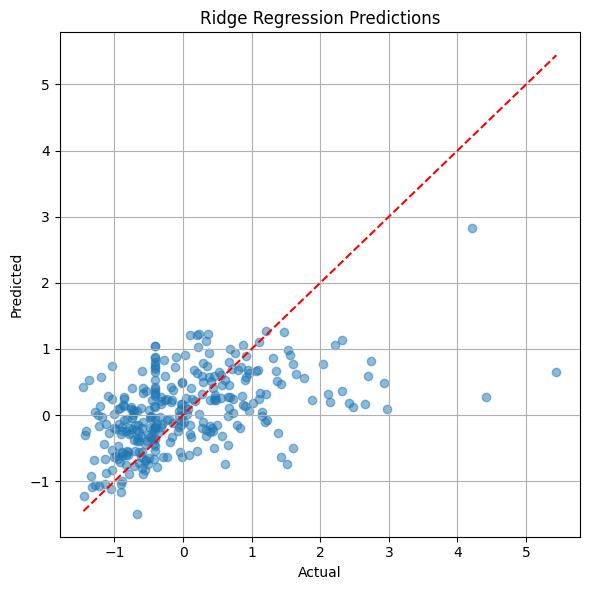

Permutation Importances
                                              Feature  Importance
14                       num__tuition_and_fees_201011    0.155344
9   num__percent_of_total_enrollment_that_are_nati...    0.107081
13     num__percent_of_freshmen_submitting_sat_scores    0.089239
12    num__percent_of_total_enrollment_that_are_white    0.026157
16                  num__offers_associates_degree_Yes    0.013405
19  num__percent_of_total_enrollment_that_are_blac...    0.012255
10  num__percent_of_freshmen__receiving_federal_gr...    0.010311
15                                       num__sat_avg    0.007527
24  num__percent_of_total_enrollment_that_are_two_...    0.006560
7   num__graduation_rate__bachelor_degree_within_4...    0.005964


In [12]:
# --- Ridge Regression ---
ridge_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RidgeCV(cv=cv))
])
model = ridge_pipeline.fit(X_train, y_train)
ridge_model = evaluate_model("Ridge Regression", model)
ridge_coefs = ridge_model.named_steps['regressor'].coef_
ridge_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': ridge_coefs})
print("Permutation Importances")
perm_importances = get_permutation_importance(ridge_model, "Ridge Regression", perm_importances)
print(perm_importances["Ridge Regression"])

**4. Decision Tree**


Decision Tree
CV R²:       0.254
CV Std:      0.087
Train R²:    0.390
Test R²:     0.134
Adjusted R²: 0.036
MSE:         0.892
RMSE:        0.945
MAE:         0.642
MAPE:        159.94%


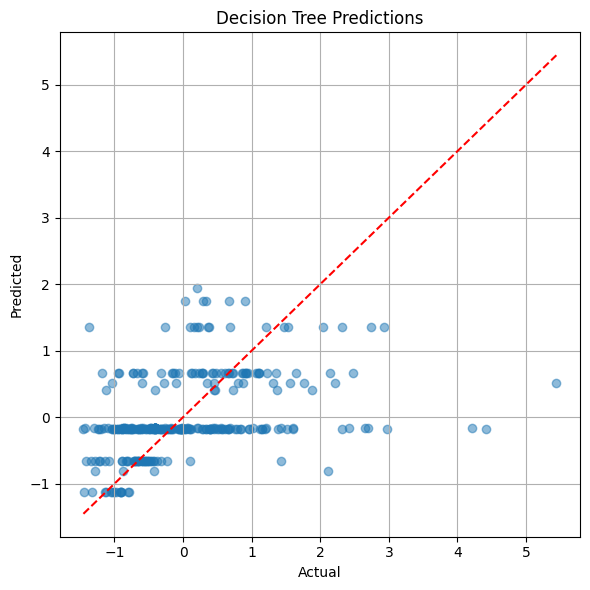

Top 10 Feature Importances:
                                              Feature  Importance
14                       num__tuition_and_fees_201011    0.452930
13     num__percent_of_freshmen_submitting_sat_scores    0.190080
19  num__percent_of_total_enrollment_that_are_blac...    0.109415
10  num__percent_of_freshmen__receiving_federal_gr...    0.072015
15                                       num__sat_avg    0.068687
1                     num__estimated_enrollment_total    0.046439
6   num__percent_of_freshmen_receiving_institution...    0.031262
4   num__percent_of_graduate_enrollment_that_are_w...    0.029173
3                 num__estimated_enrollment_part_time    0.000000
5     num__percent_of_total_enrollment_that_are_women    0.000000
Permutation Importances
                                              Feature  Importance
14                       num__tuition_and_fees_201011    0.419612
13     num__percent_of_freshmen_submitting_sat_scores    0.088277
15                      

In [13]:
# --- Decision Tree with GridSearchCV ---
dt_param_grid = {
    'regressor__max_depth': list(range(3, 11, 1)),
    'regressor__min_samples_split': list(range(2, 11, 1))
}
dt_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', DecisionTreeRegressor(random_state=42))
])
dt_grid_search = GridSearchCV(
    estimator= dt_pipeline,
    param_grid= dt_param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)
dt_grid_search.fit(X_train, y_train)
best_dt_model = dt_grid_search.best_estimator_

dt_model = evaluate_model("Decision Tree", best_dt_model)

dt_importances = best_dt_model.named_steps['regressor'].feature_importances_
dt_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': dt_importances})
dt_importance_df = dt_importance_df.sort_values(by='Importance', ascending=False)
print("Top 10 Feature Importances:")
print(dt_importance_df.head(10))

print("Permutation Importances")
perm_importances = get_permutation_importance(best_dt_model , "Decision Tree", perm_importances)
print(perm_importances["Decision Tree"])

**5. Random Forest**


Random Forest
CV R²:       0.345
CV Std:      0.052
Train R²:    0.872
Test R²:     0.310
Adjusted R²: 0.233
MSE:         0.711
RMSE:        0.843
MAE:         0.561
MAPE:        140.61%


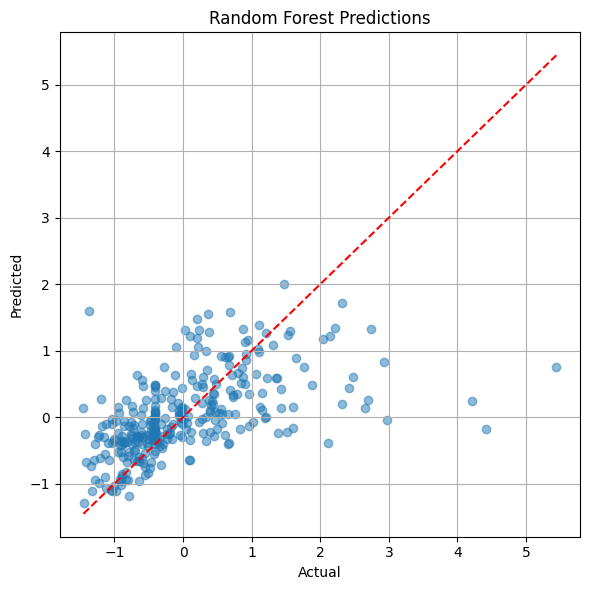

Permutation Importances
                                              Feature  Importance
14                       num__tuition_and_fees_201011    0.331279
13     num__percent_of_freshmen_submitting_sat_scores    0.156384
15                                       num__sat_avg    0.061816
1                     num__estimated_enrollment_total    0.033945
12    num__percent_of_total_enrollment_that_are_white    0.021929
10  num__percent_of_freshmen__receiving_federal_gr...    0.017567
6   num__percent_of_freshmen_receiving_institution...    0.017500
3                 num__estimated_enrollment_part_time    0.013735
4   num__percent_of_graduate_enrollment_that_are_w...    0.011292
7   num__graduation_rate__bachelor_degree_within_4...    0.009802


In [19]:
# --- Random Forest with GridSearchCV ---
rf_param_grid = {
    'regressor__max_depth': list(range(3, 11, 1)) + [None],
    'regressor__min_samples_split': list(range(2, 11, 1))
}
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

rf_grid_search = GridSearchCV(
    estimator= rf_pipeline,
    param_grid= rf_param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)
rf_grid_search.fit(X_train, y_train)
best_rf_model = rf_grid_search.best_estimator_

rf_model = evaluate_model("Random Forest", best_rf_model)

print("Permutation Importances")
perm_importances = get_permutation_importance(best_rf_model, "Random Forest", perm_importances)
print(perm_importances["Random Forest"])

**6. XGBoost**


XGBoost
CV R²:       0.350
CV Std:      0.048
Train R²:    0.679
Test R²:     0.301
Adjusted R²: 0.222
MSE:         0.720
RMSE:        0.849
MAE:         0.586
MAPE:        163.21%


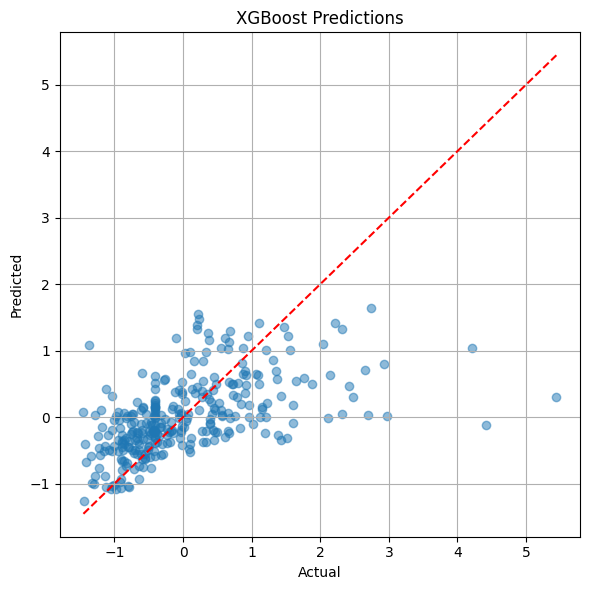

Permutation Importances
                                              Feature  Importance
14                       num__tuition_and_fees_201011    0.271110
13     num__percent_of_freshmen_submitting_sat_scores    0.104730
10  num__percent_of_freshmen__receiving_federal_gr...    0.059587
7   num__graduation_rate__bachelor_degree_within_4...    0.053275
15                                       num__sat_avg    0.031630
12    num__percent_of_total_enrollment_that_are_white    0.030342
1                     num__estimated_enrollment_total    0.029869
11    num__percent_of_total_enrollment_that_are_asian    0.023237
3                 num__estimated_enrollment_part_time    0.020612
6   num__percent_of_freshmen_receiving_institution...    0.012488


In [20]:
# --- XGBoost with GridSearchCV ---
xgb_param_grid = {
    'regressor__max_depth': list(range(3, 11, 1)),
    'regressor__learning_rate': [0.01, 0.05, 0.1, 0.2]
}
xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(random_state=42, verbosity=0))
])

xgb_grid_search = GridSearchCV(
    estimator=xgb_pipeline,
    param_grid=xgb_param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

xgb_grid_search.fit(X_train, y_train)
best_xgb_model = xgb_grid_search.best_estimator_

xgb_model = evaluate_model("XGBoost", best_xgb_model)

print("Permutation Importances")
perm_importances = get_permutation_importance(best_xgb_model, "XGBoost", perm_importances)
print(perm_importances["XGBoost"])


**7. Ensemble Model: Voting Regressor**


Voting Regressor
CV R²:       0.349
CV Std:      0.048
Train R²:    0.674
Test R²:     0.319
Adjusted R²: 0.242
MSE:         0.702
RMSE:        0.838
MAE:         0.579
MAPE:        146.57%


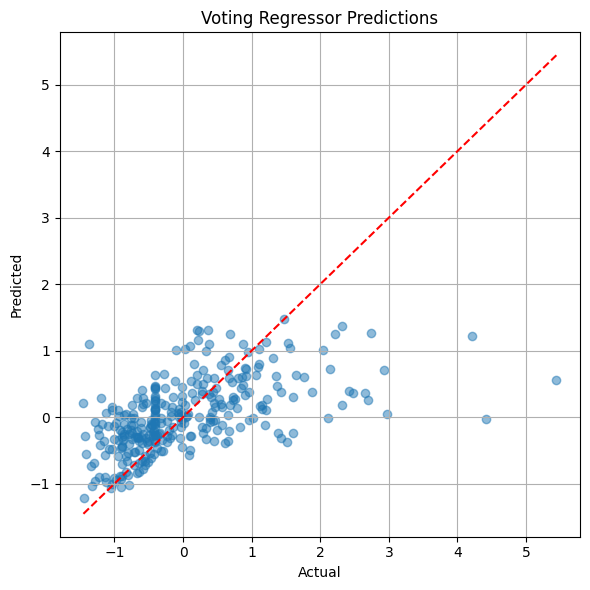

Permutation Importances
                                              Feature  Importance
14                       num__tuition_and_fees_201011    0.257031
13     num__percent_of_freshmen_submitting_sat_scores    0.109718
15                                       num__sat_avg    0.030308
9   num__percent_of_total_enrollment_that_are_nati...    0.024468
12    num__percent_of_total_enrollment_that_are_white    0.022920
1                     num__estimated_enrollment_total    0.019909
10  num__percent_of_freshmen__receiving_federal_gr...    0.018851
7   num__graduation_rate__bachelor_degree_within_4...    0.014314
3                 num__estimated_enrollment_part_time    0.013463
11    num__percent_of_total_enrollment_that_are_asian    0.011201


In [21]:
# --- Voting Regressor ---

estimators = [
    ('lasso', clone(lasso_model.named_steps['regressor'])),
    ('rf', clone(rf_model.named_steps['regressor'])),
    ('xgb', clone(xgb_model.named_steps['regressor']))
]

voting_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', VotingRegressor(estimators=estimators, n_jobs=-1))
])

model = voting_pipeline.fit(X_train, y_train)
voting_model = evaluate_model("Voting Regressor", model)

print("Permutation Importances")
perm_importances = get_permutation_importance(model, "Voting Regressor", perm_importances)
print(perm_importances["Voting Regressor"])


**8. Ensemble Model: Stacking Regressor**


Stacking Regressor
CV R²:       0.355
CV Std:      0.046
Train R²:    0.771
Test R²:     0.318
Adjusted R²: 0.241
MSE:         0.703
RMSE:        0.838
MAE:         0.572
MAPE:        152.84%


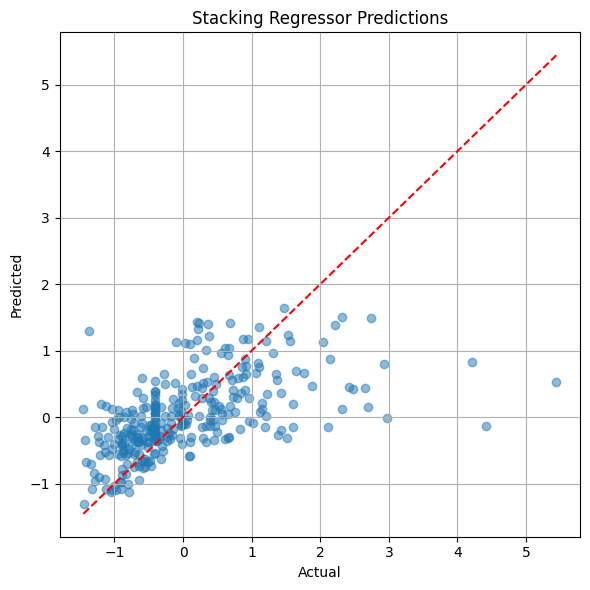

Permutation Importances
                                              Feature  Importance
14                       num__tuition_and_fees_201011    0.288806
13     num__percent_of_freshmen_submitting_sat_scores    0.123907
15                                       num__sat_avg    0.041694
10  num__percent_of_freshmen__receiving_federal_gr...    0.032267
1                     num__estimated_enrollment_total    0.029280
12    num__percent_of_total_enrollment_that_are_white    0.025434
7   num__graduation_rate__bachelor_degree_within_4...    0.024181
3                 num__estimated_enrollment_part_time    0.015942
11    num__percent_of_total_enrollment_that_are_asian    0.015231
16                  num__offers_associates_degree_Yes    0.010257


In [22]:
# --- Stacking Regressor ---
estimators = [
    ('lasso', clone(lasso_model.named_steps['regressor'])),
    ('rf', clone(rf_model.named_steps['regressor'])),
    ('xgb', clone(xgb_model.named_steps['regressor']))
]
stacking_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', StackingRegressor(estimators=estimators, final_estimator=RidgeCV(), cv=cv, n_jobs=-1))
])
model = stacking_pipeline.fit(X_train, y_train)
stacking_model = evaluate_model("Stacking Regressor", model)
print("Permutation Importances")
perm_importances = get_permutation_importance(stacking_model, "Stacking Regression", perm_importances)
print(perm_importances["Stacking Regression"])

# **Performance Summary**

**Actual VS Predicted Summary**

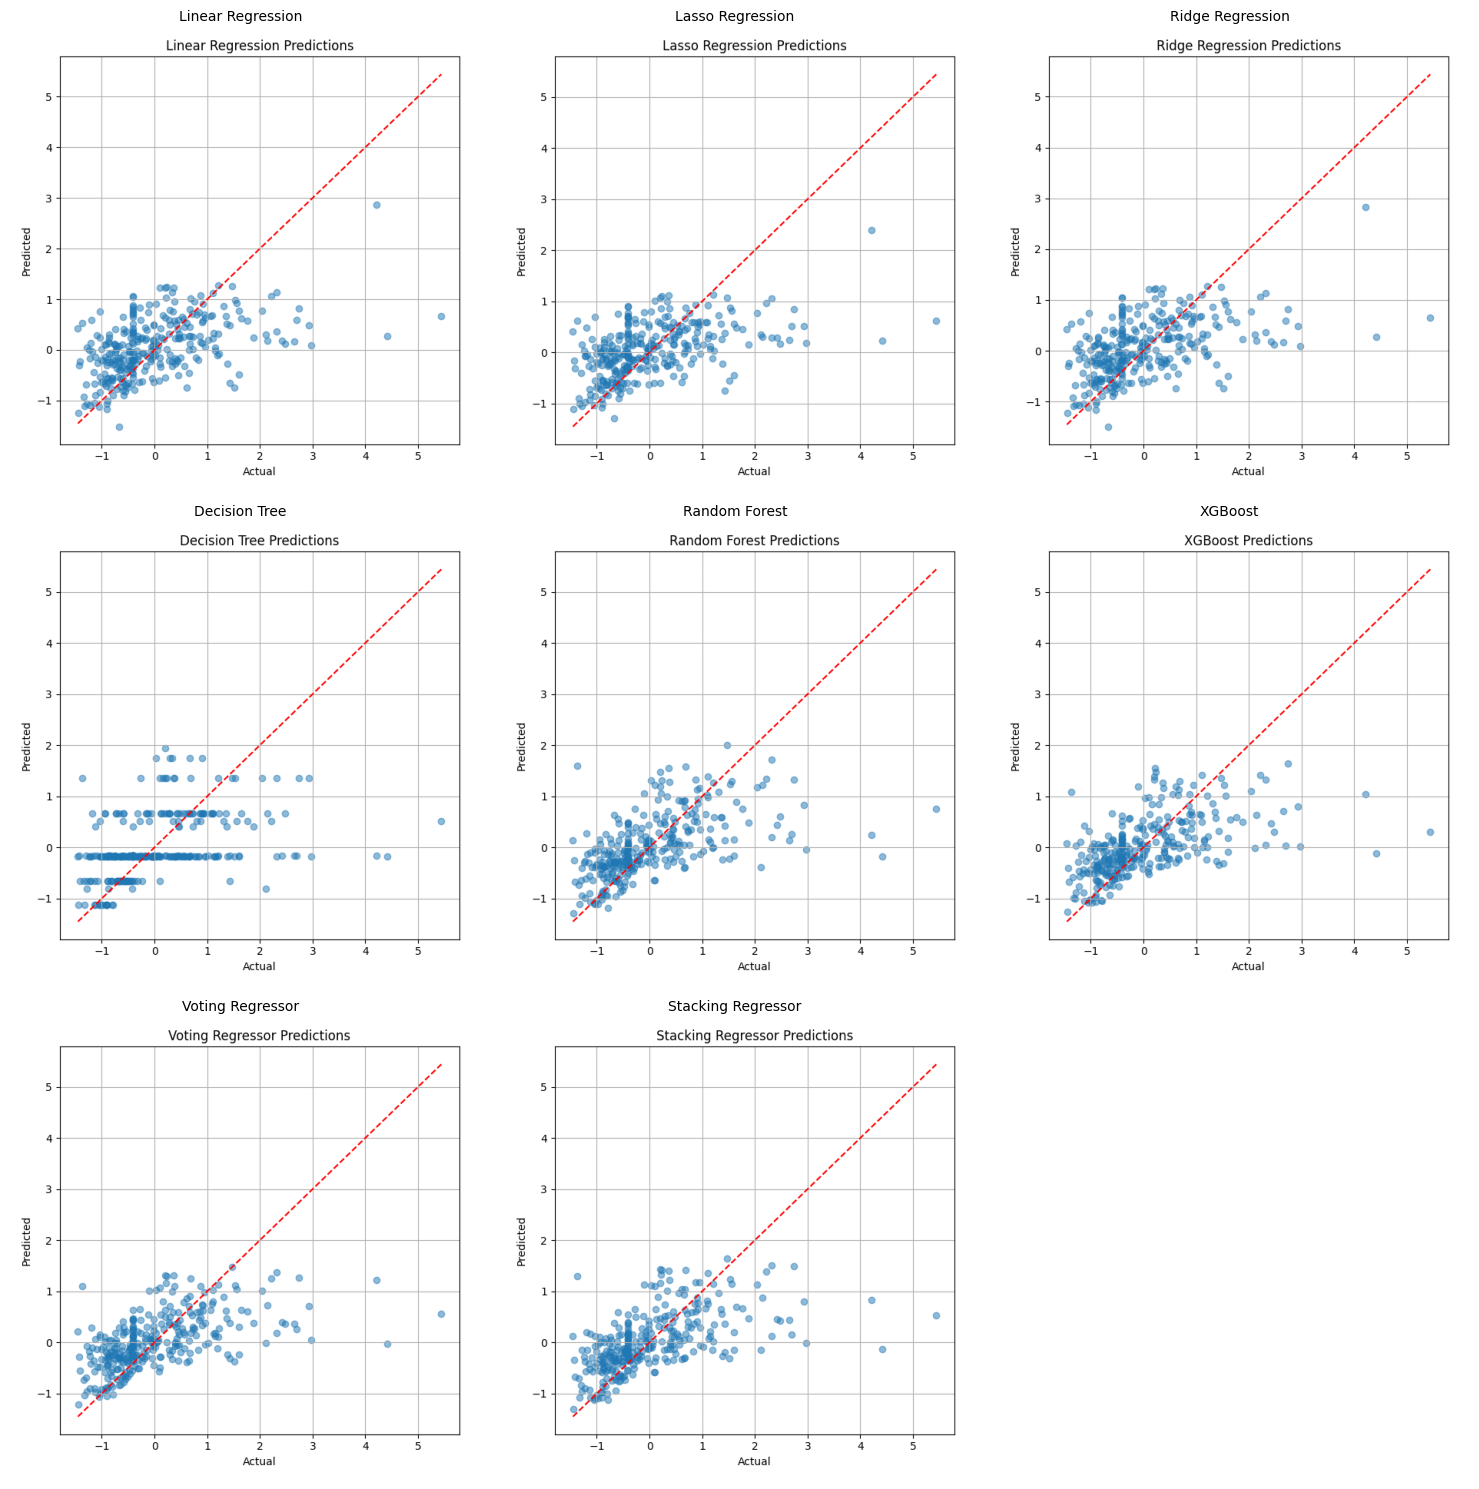

In [24]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

def combine_actual_vs_predicted_plots(save_dir='plots'):
    # Desired order of models
    model_order = [
        "Linear Regression", "Lasso Regression", "Ridge Regression",
        "Decision Tree", "Random Forest", "XGBoost",
        "Voting Regressor", "Stacking Regressor"
    ]

    # Match plot files in the specified order
    plot_files = []
    for model in model_order:
        filename = model + "_actual_vs_predicted.png"
        if filename in os.listdir(save_dir):
            plot_files.append(filename)

    num_plots = len(plot_files)
    num_rows, num_cols = 3, 3  # 3x3 grid

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))
    axes = axes.flatten()

    for i in range(num_rows * num_cols):
        if i < num_plots:
            img_path = os.path.join(save_dir, plot_files[i])
            img = mpimg.imread(img_path)
            axes[i].imshow(img)
            axes[i].set_title(model_order[i], fontsize=10)
        axes[i].axis('off')

    plt.tight_layout()
    plt.savefig(f"plots_acceptance_rate/summary_actual_predicted.png")
    plt.show()

# Run the function
combine_actual_vs_predicted_plots('plots_acceptance_rate')


**Model Evaluation Summary**

<ipython-input-25-d7ac7ba68919>:15: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="Model", y="Score", hue="Metric", data=results_long, ci=None)


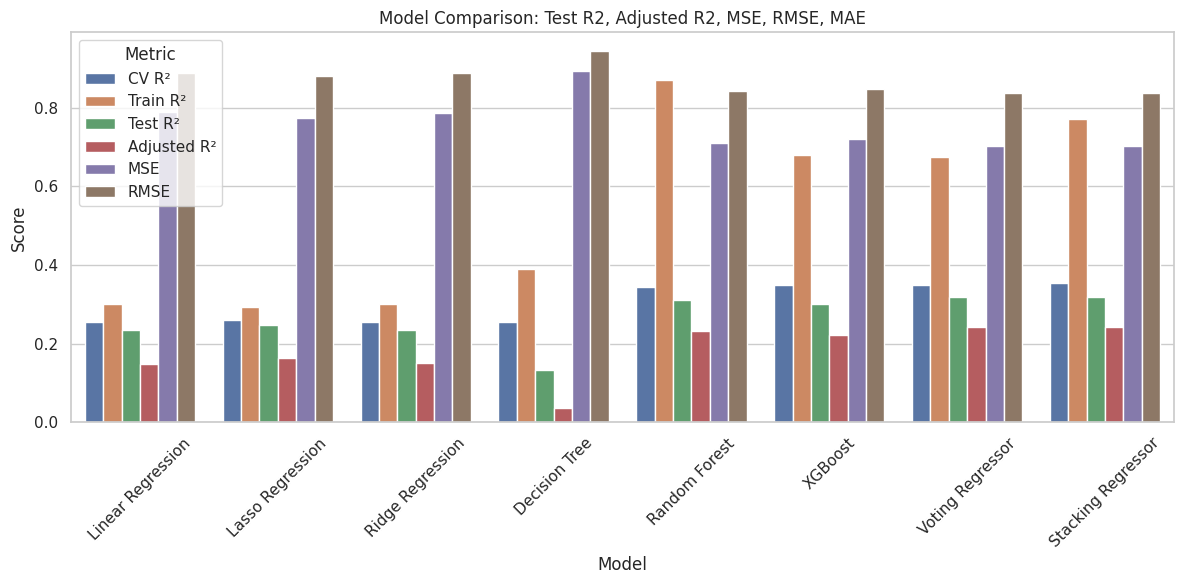

In [25]:
# Convert the model results to a DataFrame
results_df = pd.DataFrame(model_results)

# Reshape the DataFrame for side-by-side comparison
metrics_to_plot = ['CV R²', 'Train R²', 'Test R²', 'Adjusted R²', 'MSE', 'RMSE']

results_long = pd.melt(results_df, id_vars=['Model'], value_vars=metrics_to_plot,
                       var_name='Metric', value_name='Score')

# Set the figure size and plotting style
plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")

# Create the side-by-side bar plot
sns.barplot(x="Model", y="Score", hue="Metric", data=results_long, ci=None)

# Add labels and title
plt.title("Model Comparison: Test R2, Adjusted R2, MSE, RMSE, MAE")
plt.ylabel("Score")
plt.xticks(rotation=45)  # Rotate model names for better readability
plt.tight_layout()
plt.savefig(f"plots_acceptance_rate/summary_model_evaluations.png")
# Show the plot
plt.show()



**Permutation Importance Summary**

In [27]:
def plot_permutation_importances(perm_importances):
    # Set the number of models
    n_models = len(perm_importances)

    # Get the feature names and the maximum importance value for scaling
    feature_names = perm_importances[list(perm_importances.keys())[0]]['Feature']
    max_importance = max([df['Importance'].max() for df in perm_importances.values()])

    # Set up the figure and axes for side-by-side plots
    fig, ax = plt.subplots(figsize=(12, 8))

    # Number of bars per model
    width = 0.8 / n_models
    index = np.arange(len(feature_names))

    # Plot each model's permutation importance side by side
    for i, (model_name, importance_df) in enumerate(perm_importances.items()):
        # Shift the bars by width for each model
        ax.barh(index + i * width, importance_df['Importance'], height=width, label=model_name)

    # Labeling the axes and title
    ax.set_yticks(index + width * (n_models - 1) / 2)
    ax.set_yticklabels(feature_names)
    ax.set_xlabel('Permutation Importance')
    ax.set_title('Permutation Importance for Different Models')

    # Show legend and tight layout for better fitting
    ax.legend(loc='upper right')
    plt.tight_layout()
    plt.savefig(f"plots_acceptance_rate/summary_perm_importances.png")
    # Display the plot
    plt.show()



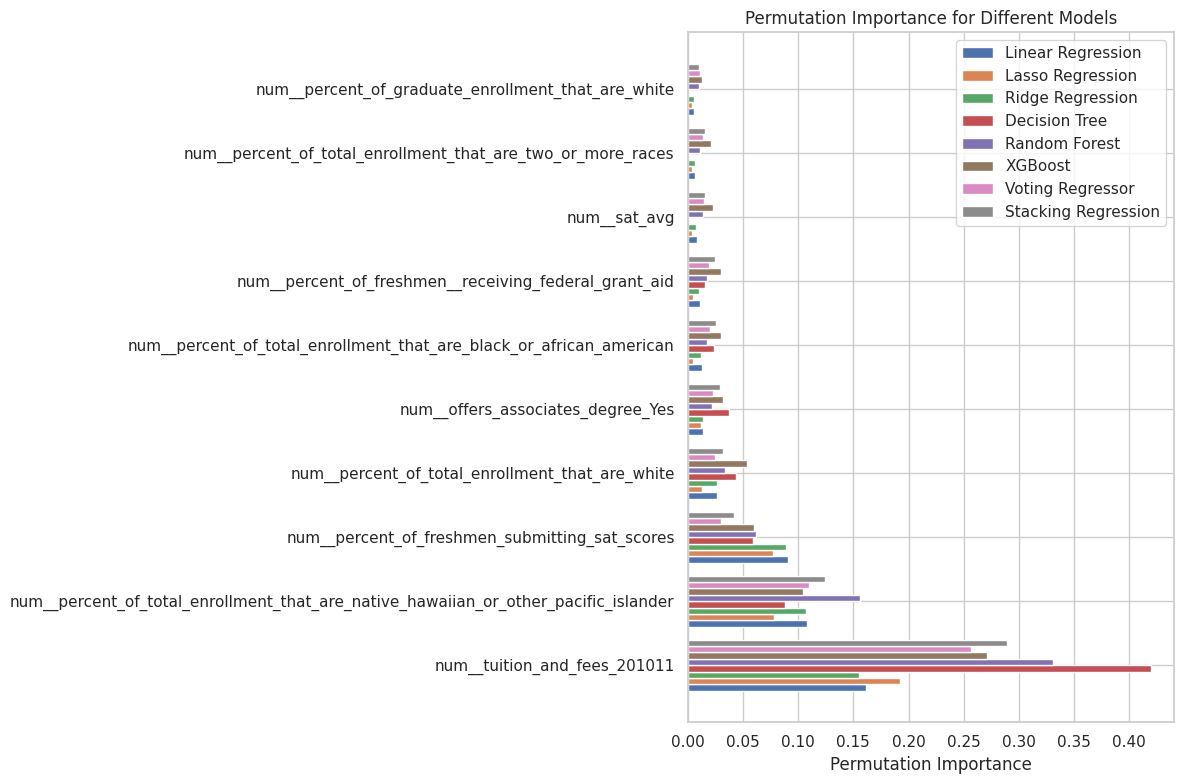

In [28]:
plot_permutation_importances(perm_importances)

# **Choose a Model**

Random Forest

In [30]:
best_rf_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['percent_of_graduate_enrollment_that_are_black_or_african_american',
                                                   'estimated_enrollment_total',
                                                   'associates_degrees_awarded',
                                                   'estimated_enrollment_part_time',
                                                   'percent_of_graduate_enrollment_that_are_women',
                                                   'percent_of_total_enrollment_that_are_women',
                                                   'percent_...
                                                   'certificates_of_1_but_less_than_2years_awarded',
                                                   'percent_of_total_enrollment_that_are_two_or_more_races',
                                                   'geographic_region_Great '
                                                   'Lakes IL IN MI OH WI',
                                                   'fips_state_code_New York',
                                                   'percent_of_graduate_enrollment_that_are_white']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Cluster'])])),
                ('regressor',
                 RandomForestRegressor(min_samples_split=5, random_state=42))])

In [31]:
rf_grid_search.best_params_

{'regressor__max_depth': None, 'regressor__min_samples_split': 5}

In [32]:
# Step 1: Get the fitted preprocessor and regressor from pipeline
preprocessor = best_rf_model.named_steps['preprocessor']
regressor = best_rf_model.named_steps['regressor']

# Step 2: Extract feature names from the preprocessor
def get_feature_names(preprocessor):
    feature_names = []

    for name, transformer, cols in preprocessor.transformers_:
        if name == 'remainder' and transformer == 'drop':
            continue
        elif name == 'remainder' and transformer == 'passthrough':
            feature_names.extend(cols)
        else:
            # Handle OneHotEncoder specifically
            if hasattr(transformer, 'get_feature_names_out'):
                try:
                    names = transformer.get_feature_names_out(cols)
                except TypeError:
                    names = transformer.get_feature_names_out()
                feature_names.extend(names)
            else:
                # If transformer doesn't change feature names
                feature_names.extend(cols)

    return feature_names

# Step 3: Get the processed feature names
feature_names = get_feature_names(preprocessor)

# Step 4: Match feature importances with names
import pandas as pd

importances = regressor.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# View top features
print(feature_importance_df.head(10))


                                              Feature  Importance
14                            tuition_and_fees_201011    0.264960
13          percent_of_freshmen_submitting_sat_scores    0.115861
10   percent_of_freshmen__receiving_federal_grant_aid    0.065332
15                                            sat_avg    0.062680
12         percent_of_total_enrollment_that_are_white    0.051877
1                          estimated_enrollment_total    0.046900
19  percent_of_total_enrollment_that_are_black_or_...    0.045261
7   graduation_rate__bachelor_degree_within_4_year...    0.044596
6   percent_of_freshmen_receiving_institutional_gr...    0.038078
4       percent_of_graduate_enrollment_that_are_women    0.033582
